In here I am going to attempt to build a Neural_Network class from scratch and test it on both simple multi-class classification problem.
Neural network works by 


In [32]:
%matplotlib inline
pylab.rcParams['figure.figsize'] = (12.0, 8.0)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from scipy.stats import linregress
from sklearn.model_selection import train_test_split
import itertools
import logging

class Neural_network():
    def __init__(self, X = np.array, y = np.array, hidden_layer_size  = tuple, alpha = float, num_iter = int, lamb = float):
        self.X = X
        # each element in y needs to be converted into the representative vector to allow computation
        self.y_class = y
        self.unique_class = np.unique(y).tolist()
        #dataset is a numpy array with both the X and y (class representation) axis.
        self.dataset = np.concatenate((self.X, self.y_class.reshape(-1,1)), axis = 1)
        # convert the label into vector representation
        self.y = self.label_convert(y)            
        self.alpha = alpha
        self.num_iter = num_iter
        self.num_layer = len(hidden_layer_size) + 2
        # initialise the weight matrix here
        # the weight matrix of each layer is stored as elements inside a list
        # there should be (len(whole_network_size) - 1) number of weight matx
        self.weights = []

        self.number_of_output = np.unique(y).size
        self.whole_network_size = (X.shape[1],) + hidden_layer_size + (self.number_of_output,)
        for i in range(len(self.whole_network_size) - 1):
            ### initial weight shouldn't be zero
            d = self.whole_network_size[i] + 1 # +1 to account for bias unit
            limit = np.sqrt(1/d)
            # the weight is a N x M matrix, where N is number of unit in the next layer, and M is the number of unit of \ 
            # current layer + 1 bias unit
            weight = np.random.uniform(-limit, limit, (self.whole_network_size[i+1], self.whole_network_size[i] + 1))
 #           weight = np.zeros()
            self.weights.append(weight)
        self.lamb = lamb
        self.M = self.X.shape[0]
        
    def sigmoid(self, z = np.array):
        h = 1/(1+np.exp(-z))
        return h
    def softmax(self, z = np.array):
        #compute softmax of z (z is an N x M array, where N is the number of features and M is the number of training examples)
        h = np.exp(z)/np.sum(np.exp(z), axis = 0)
        return h
    def forward_propagation(self, x = np.array):
        # this is perform on one training example each time, and return the output as vector
        # for now only use sigmoid function for activation hiddent and input layer
        # forward propagation compute the sigmoid output of the dot product of Wi and ai up to the second last layer.
        # the output of that would be the next layer input 
        # current_input is a N x M matrix, where N is the number of features and M is the number of examples
        # the input (a) of each layer is stored in a list as vectors and has the structure of input layer + hidden layer

        inputs = []
 #       print (x)
        # start off with the features (X) as the first layer input (with bias unit). Input can always be expressed as a vector
        current_input = np.concatenate((np.ones((x.shape[0], 1)), x), axis = 1).T.astype(np.float64)
  #      current_input = np.insert(x, 0, 1.0).astype(np.float64).reshape(-1,1)
        if current_input.shape != (x.shape[1]+1,x.shape[0]):
            logging.warning("initial current_input shape is " + str(current_input.shape) + " when it is supposed to be " + str((x.shape[1]+1,x.shape[0])))
            
  #      current_input = np.concatenate(np.ones(x.shape), x).T
        inputs.append(current_input)
        for i in range(len(self.whole_network_size) -2):
            z = np.dot(self.weights[i], current_input)
            if z.shape != (self.whole_network_size[i+1], x.shape[0]):
                logging.warning("z shape is " + str(z.shape) + " when it is supposed to be " + str((self.whole_network_size[i+1], x.shape[0])))
            h = self.sigmoid(z)
            #add a bias unit to each training example
            current_input = np.concatenate((np.ones((1, x.shape[0])), h), axis = 0).astype(np.float64)
       #     current_input = np.insert(h, 0, 1.0).astype(np.float64).reshape(-1,1)
            if current_input.shape != (self.whole_network_size[i+1] + 1,x.shape[0]):
                logging.warning("current_input shape is " + str(current_input.shape) + " when it is supposed to be " + str((self.whole_network_size[i+1] + 1,x.shape[0])))
            inputs.append(current_input)
        #use softmax for final layer to compute the output, current input is now the input of the final hidden layer
        z = np.dot(self.weights[-1], current_input)
        if z.shape != (self.whole_network_size[-1], x.shape[0]):
            logging.warning("final z shape is " + str(z.shape))
            
        #output has the shape N x M, where N is the features and M is the number of training example
            
        output = self.softmax(z)  
        
        
        return (inputs, output)
    def backward_propagation(self, inputs = list, output = np.array, y_label = np.array):
        # deltas is a list of vectors with shape identical to the corresponding neuron node of each layers 
        # gradients is a list of matrices of the gradient of cost functions. such list and matrices should have the \
        # same shape as the list weights
        # back prop is performed on 1 training example each time (stochastic)
        global gradients
        global deltas
        deltas = []
        gradients = []

        #compute the delta value of the last layer (output layer) first then propagate backward with loop
        delta = (output - y_label).reshape(-1,1)
#         print (output)
#         print (y_label)
        if delta.shape != output.shape:
            logging.warning("initial delta shape is " + str(delta.shape))            
        deltas.append(delta)
        
        
#         print (deltas)
        # working backward from the last hidden layer, the gradient is computed and stored.
        # the delta value of such layer is then computed and stored
        # for the last layer (input), there's no regularisation term
        for i in range(len(self.whole_network_size)-2, -1, -1):
      #      print (i)
            if i == 0:
                lamb = 0
            else:
                lamb = self.lamb
                
            # if gradient return a single number, it's wrong. Should be the same shape as weight.
            if i == len(self.whole_network_size)-2:
                if delta.shape != (self.weights[i].shape[0], 1):
                    logging.warning(str(i) +" delta shape is" + str(delta.shape) + " when it is supposed to be " + str((self.weights[i].shape[0], 1)))
            else:
                if delta.shape != (self.weights[i].shape[0], 1):
                    logging.warning(str(i) +" delta shape is" + str(delta.shape) + " when it is supposed to be " + str((self.weights[i].shape[0], 1)))
                
            if inputs[i].T.shape != (1, self.weights[i].shape[1]):
                logging.warning("input shape is" + str(inputs[i].T.shape))
                
            gradient = np.dot(delta, inputs[i].T)  + (self.lamb/ self.M) * self.weights[i]
#             if gradient.shape != (self.weights[i].shape:
#                 logging.warning("gradient shape is" + str(gradient.shape)  when it should be )
                
            gradients.insert(0, gradient)
            
            delta = np.dot(self.weights[i].T, delta) * inputs[i] * (1 - inputs[i])
            delta = np.delete(delta, 0, axis = 0)
            deltas.insert(0, delta)
#            print (deltas)
        # check if shape of gradients is the same as weights
        for i in range(len(gradients)):
            if gradients[i].shape != self.weights[i].shape:
                logging.warning("gradient shape is" + str(gradient.shape))
        return gradients

    def gradient_descent(self, gradients = list):
        #gradients should have the exact same structure as weights (list of matrices)
        for i in range(len(self.weights)):
            self.weights[i] = self.weights[i] - self.alpha * gradients[i] # regularisation term already taken into account during back prop
    def label_convert(self, y):
        converted_output = []
        for label in y:
            output_vector = np.zeros(np.unique(y).size)
            index_num = self.unique_class.index(label)
            output_vector[index_num] = 1
            converted_output.append(output_vector)
        return np.array(converted_output)    
        
        
    def fit(self):
        global inputs
        losses = {}
        step = 0
        np.random.shuffle(self.dataset)
        X_shuffled, y_shuffled = np.hsplit(self.dataset, [self.dataset.shape[1]- 1,])
        y_shuffled = self.label_convert(y_shuffled)  
        for index in itertools.cycle(range(X_shuffled.shape[0])):
            x = X_shuffled[index].reshape(1,-1)
            inputs, output = self.forward_propagation(x)
            
            #compute the loss function here before gradient descent for every 10 iteration
            if step %10 == 0:
                _, outputs = self.forward_propagation(X_shuffled)
                loss = (-1/y_shuffled.shape[0]) * np.sum(y_shuffled * np.log(outputs.T))
                losses[step] = loss
            
            #update the weight
            gradients = self.backward_propagation (inputs = inputs, output = output, y_label = y_shuffled[index].reshape(-1,1))
            self.gradient_descent(gradients = gradients)    
            step += 1
            
            #if number of iteration specified met, stop optimising.
            if step > self.num_iter:
                break
        
        return (losses)
    def predict(self, X_test = np.array):
        global outputs
        global class_output
        class_output = []
        #convert the vector into the corresponding class with the highest score,
        inputs, outputs = self.forward_propagation(X_test)
        outputs[outputs == np.max(outputs, axis = 0)] = 1
        outputs[outputs != np.max(outputs, axis = 0)] = 0
        for output in outputs.T.tolist():
            index_num = output.index(1)
            clas = self.unique_class[index_num]
            class_output.append(clas)

        return np.array(class_output)

    def score(self, X_test = np.array, y_test = np.array):
        #compare the output to the actual label and work out the accuracy ratio.
        predicted_outputs = self.predict(X_test)
        accu = (predicted_outputs == y_test).sum()/len(predicted_outputs)
        return accu          

In [46]:
np.random.seed(10)
A = np.random.multivariate_normal([7, 6], [[2, 1],[1, 2]], 1000)
B = np.random.multivariate_normal([3, 0], [[2, 1],[1, 2]], 1000)
C = np.random.multivariate_normal([0, 4], [[2, 1],[1, 2]], 1000)
X = np.concatenate((A, B, C))
y = np.concatenate((np.array(["A" for i in range(A.shape[0])]), 
                    np.array(["B" for i in range(B.shape[0])]), 
                    np.array(["C" for i in range(C.shape[0])])))
cm = y.copy()
cm[cm == "A"] = 1
cm[cm == "B"] =2
cm[cm =="C"] =3
plt.figure()
plt.scatter(np.array([i[0] for i in X]), np.array([i[1] for i in X]), c = cm, alpha = 0.7)
#plt.scatter(*np.hsplit(X, 2), c = y)
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 1)


0.96999999999999997

In [ ]:
C = Neural_network(X_train, y_train, hidden_layer_size = (100,), alpha = 0.1, num_iter = 200, lamb = 0)
losses = C.fit()
C.score(X_test, y_test)

In [47]:
mlp = MLPClassifier(hidden_layer_sizes = (100,), activation = "logistic", solver = "sgd", max_iter=100,alpha=0.01, shuffle = True, learning_rate = "constant")
mlp = mlp.fit(X_train,y_train)
mlp.score(X_test, y_test)


C:\Users\user\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.98333333333333328

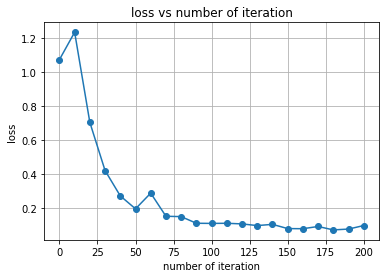

In [48]:
plt.figure()
plt.title("loss vs number of iteration")
plt.ylabel("loss")
plt.xlabel("number of iteration")
plt.grid()
plt.plot(list(losses.keys()), list(losses.values()), marker = "o")


In [ ]:
mlp.coefs_

In [ ]:
W

In [ ]:
np.array([i for i in range(15)]).reshape(3,5) , np.array([2 for i in range(15)]).reshape(3,5)

In [ ]:
import numpy as np
